##  Introducción

En esta sección se realiza un **Análisis Exploratorio de Datos (EDA)** con el objetivo de comprender la estructura, calidad y comportamiento general de las tres fuentes de información proporcionadas: `prints.json`, `taps.json` y `pays.csv`.

Este análisis permitirá **contextualizar los datos** antes de diseñar el pipeline de ingeniería requerido, identificando aspectos clave como:

- Distribución de los eventos a lo largo del tiempo.
- Formato de las variables (fechas, identificadores, estructuras anidadas).
- Presencia de valores **nulos**, **duplicados** o inconsistencias.
- Frecuencia y variedad de las `value_prop` mostradas o clickeadas por los usuarios.

Entender estas características es fundamental para asegurar un procesamiento correcto de los datos en las siguientes etapas, como la construcción de variables históricas y la preparación del dataset final para entrenamiento del modelo.


In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar los DataFrames desde los archivos CSV y JSON

df_pays = pd.read_csv("../data/pays.csv", encoding="utf-8")

df_prints = pd.read_json("../data/prints.json", lines=True)

df_taps = pd.read_json("../data/taps.json", lines=True)

In [3]:
# Explorar las columnas de df_pays
df_pays.columns

Index(['pay_date', 'total', 'user_id', 'value_prop'], dtype='object')

In [4]:
# Vista previa de df_pays
df_pays

,pay_date,total,user_id,value_prop
0,2020-11-01,7.04,35994,link_cobro
1,2020-11-01,37.36,79066,cellphone_recharge
2,2020-11-01,15.84,19321,cellphone_recharge
3,2020-11-01,26.26,19321,send_money
4,2020-11-01,35.35,38438,send_money
...,...,...,...,...
756478,2020-11-30,17.76,74524,send_money
756479,2020-11-30,111.02,42594,transport
756480,2020-11-30,0.81,1338,transport
756481,2020-11-30,34.71,1338,credits_consumer


In [5]:
# Convertir la columna 'pay_date' a tipo datetime
df_pays["pay_date"] = pd.to_datetime(df_pays["pay_date"])

In [6]:
# Explorar las columnas de df_prints
df_prints.columns

Index(['day', 'event_data', 'user_id'], dtype='object')

In [7]:
df_prints

,day,event_data,user_id
0,2020-11-01,"{'position': 0, 'value_prop': 'cellphone_recha...",98702
1,2020-11-01,"{'position': 1, 'value_prop': 'prepaid'}",98702
2,2020-11-01,"{'position': 0, 'value_prop': 'prepaid'}",63252
3,2020-11-01,"{'position': 0, 'value_prop': 'cellphone_recha...",24728
4,2020-11-01,"{'position': 1, 'value_prop': 'link_cobro'}",24728
...,...,...,...
508612,2020-11-30,"{'position': 0, 'value_prop': 'send_money'}",50807
508613,2020-11-30,"{'position': 1, 'value_prop': 'prepaid'}",50807
508614,2020-11-30,"{'position': 2, 'value_prop': 'credits_consumer'}",50807
508615,2020-11-30,"{'position': 0, 'value_prop': 'point'}",1487


In [8]:
df_taps.columns

Index(['day', 'event_data', 'user_id'], dtype='object')

In [9]:
df_taps

,day,event_data,user_id
0,2020-11-01,"{'position': 0, 'value_prop': 'cellphone_recha...",98702
1,2020-11-01,"{'position': 2, 'value_prop': 'point'}",3708
2,2020-11-01,"{'position': 3, 'value_prop': 'send_money'}",3708
3,2020-11-01,"{'position': 0, 'value_prop': 'transport'}",93963
4,2020-11-01,"{'position': 1, 'value_prop': 'cellphone_recha...",93963
...,...,...,...
50854,2020-11-30,"{'position': 2, 'value_prop': 'credits_consumer'}",64149
50855,2020-11-30,"{'position': 1, 'value_prop': 'point'}",3329
50856,2020-11-30,"{'position': 1, 'value_prop': 'cellphone_recha...",77012
50857,2020-11-30,"{'position': 2, 'value_prop': 'cellphone_recha...",14704


## Expansión de la columna `event_data`

Los archivos `prints.json` y `taps.json` contienen una columna llamada `event_data`, la cual almacena información adicional en formato de diccionario (por ejemplo, `{"position": 0, "value_prop": "cellphone_recharge"}`).

Para poder trabajar con estos datos de forma tabular y aprovechar las variables contenidas en `event_data`, es necesario **expandir dicho diccionario en columnas separadas**.

A continuación, se aplican los siguientes pasos:

1. **Expandir el diccionario `event_data`** utilizando `apply(pd.Series)`, lo que convierte cada clave del diccionario en una columna.
2. **Combinar las columnas expandidas** con el resto del DataFrame original, eliminando la columna original `event_data`.
3. **Convertir la columna `day`** a tipo `datetime`, para facilitar su manipulación posterior en análisis temporales o filtrado por fechas.

Este paso es crucial para estructurar correctamente los datos antes de aplicar filtros, agregaciones o generar las variables históricas que alimentarán el dataset final.


In [10]:
# Expandir el diccionario en 'event_data' para df_prints
df_prints_event_data = df_prints["event_data"].apply(pd.Series)

# Combinar columnas planas con las expandidas

df_prints_nuevo = pd.concat([df_prints.drop(columns=["event_data"]), df_prints_event_data], axis=1)

# Convertir la columna 'day' a tipo datetime
df_prints_nuevo["day"] = pd.to_datetime(df_prints_nuevo["day"])

# Mostrar el DataFrame resultante
df_prints_nuevo

,day,user_id,position,value_prop
0,2020-11-01,98702,0,cellphone_recharge
1,2020-11-01,98702,1,prepaid
2,2020-11-01,63252,0,prepaid
3,2020-11-01,24728,0,cellphone_recharge
4,2020-11-01,24728,1,link_cobro
...,...,...,...,...
508612,2020-11-30,50807,0,send_money
508613,2020-11-30,50807,1,prepaid
508614,2020-11-30,50807,2,credits_consumer
508615,2020-11-30,1487,0,point


In [11]:
# Explorar las columnas de df_prints_nuevo con los datos expandidos
df_prints_nuevo.columns

Index(['day', 'user_id', 'position', 'value_prop'], dtype='object')

In [9]:
df_prints_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508617 entries, 0 to 508616
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   day         508617 non-null  datetime64[ns]
 1   user_id     508617 non-null  int64         
 2   position    508617 non-null  int64         
 3   value_prop  508617 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 15.5+ MB


In [15]:
df_prints_nuevo[df_prints_nuevo["user_id"] == 45538]

,day,user_id,position,value_prop
155799,2020-11-09,45538,0,send_money
293679,2020-11-18,45538,0,cellphone_recharge
293680,2020-11-18,45538,1,link_cobro
293681,2020-11-18,45538,2,credits_consumer
293682,2020-11-18,45538,3,send_money
504780,2020-11-30,45538,0,credits_consumer


In [16]:
# Expandir el diccionario en 'event_data' para df_taps
df_taps_event_data = df_taps["event_data"].apply(pd.Series)

# Combinar columnas planas con las expandidas
df_taps_nuevo = pd.concat([df_taps.drop(columns=["event_data"]), df_taps_event_data], axis=1)

# Convertir la columna 'day' a tipo datetime
df_taps_nuevo["day"] = pd.to_datetime(df_taps_nuevo["day"])

# Mostrar el DataFrame resultante
df_taps_nuevo

,day,user_id,position,value_prop
0,2020-11-01,98702,0,cellphone_recharge
1,2020-11-01,3708,2,point
2,2020-11-01,3708,3,send_money
3,2020-11-01,93963,0,transport
4,2020-11-01,93963,1,cellphone_recharge
...,...,...,...,...
50854,2020-11-30,64149,2,credits_consumer
50855,2020-11-30,3329,1,point
50856,2020-11-30,77012,1,cellphone_recharge
50857,2020-11-30,14704,2,cellphone_recharge


In [18]:
df_prints_nuevo[df_prints_nuevo["user_id"] == 45538]

,day,user_id,position,value_prop
155799,2020-11-09,45538,0,send_money
293679,2020-11-18,45538,0,cellphone_recharge
293680,2020-11-18,45538,1,link_cobro
293681,2020-11-18,45538,2,credits_consumer
293682,2020-11-18,45538,3,send_money
504780,2020-11-30,45538,0,credits_consumer


In [17]:
df_taps_nuevo[df_taps_nuevo["user_id"] == 45538]

,day,user_id,position,value_prop
29460,2020-11-18,45538,3,send_money


In [13]:
# Mostrar el tamaño del DataFrame resultante
df_prints_nuevo.shape

(508617, 4)

In [14]:
# Mostrar los tipos de datos de las columnas del DataFrame resultante
df_prints_nuevo.dtypes

day           datetime64[ns]
user_id                int64
position               int64
value_prop            object
dtype: object

In [15]:
# Mostrar información general del DataFrame resultante
df_prints_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508617 entries, 0 to 508616
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   day         508617 non-null  datetime64[ns]
 1   user_id     508617 non-null  int64         
 2   position    508617 non-null  int64         
 3   value_prop  508617 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 15.5+ MB


In [16]:
# Mostrar el número de filas duplicadas en el DataFrame resultante
df_prints_nuevo.duplicated().sum()

np.int64(0)

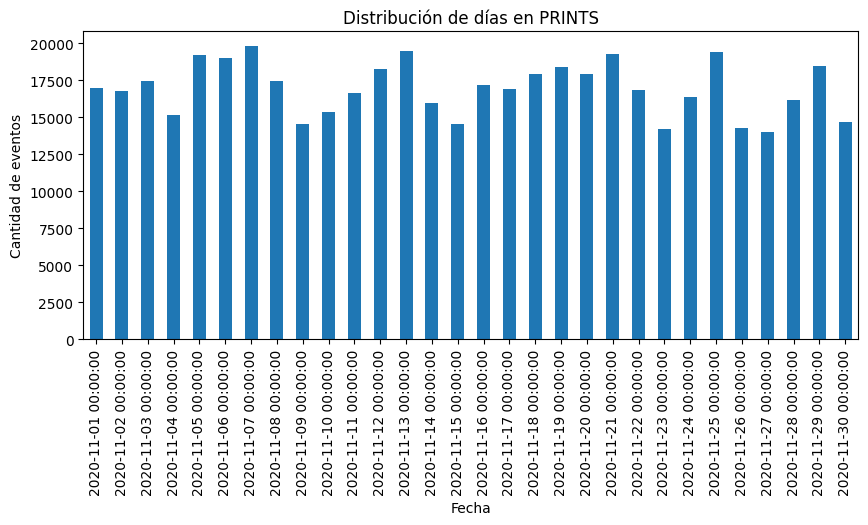

In [17]:
# Mostrar la distribución de 'value_prop' en PRINTS
df_prints_nuevo.groupby("day").size().sort_index().plot(
    kind="bar",
    figsize=(10, 4),
    title="Distribución de días en PRINTS"
)
plt.xticks(rotation=90)
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.show()


C:\Users\ingju\AppData\Local\Temp\ipykernel_31236\530574352.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = dict(zip(unique_weeks, cm.get_cmap("tab10").colors[:len(unique_weeks)]))


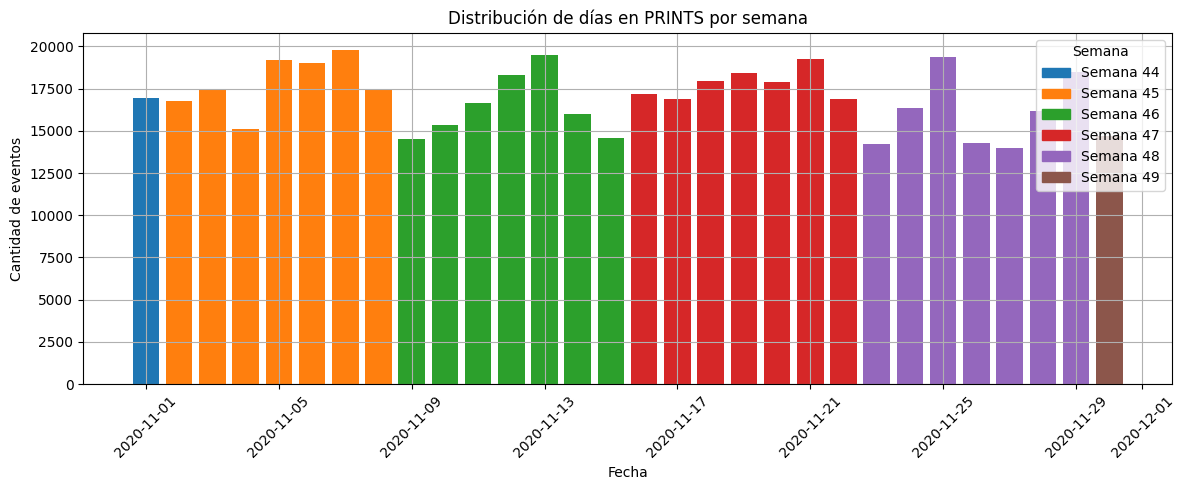

In [18]:
# Importar librerías necesarias para la visualización
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Paso 1: Crear la columna 'day' y calcular la semana

df_prints_nuevo["week"] = pd.to_datetime(df_prints_nuevo["day"]).dt.isocalendar().week

# Paso 2: Contar eventos por día
conteo_dias = df_prints_nuevo.groupby("day").size().sort_index()
fechas = conteo_dias.index

# Paso 3: Asignar color por semana
weeks = pd.to_datetime(fechas).isocalendar().week
unique_weeks = sorted(weeks.unique())
color_map = dict(zip(unique_weeks, cm.get_cmap("tab10").colors[:len(unique_weeks)]))
colors = [color_map[w] for w in weeks]

# Paso 4: Pintar la gráfica con colores por semana
plt.figure(figsize=(12, 5))
plt.bar(fechas, conteo_dias.values, color=colors)
plt.xticks(rotation=45)
plt.title("Distribución de días en PRINTS por semana")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.grid(True)

# Leyenda
handles = [plt.Rectangle((0,0),1,1, color=color_map[w]) for w in unique_weeks]
labels = [f"Semana {w}" for w in unique_weeks]
plt.legend(handles, labels, title="Semana")

plt.tight_layout()
plt.show()


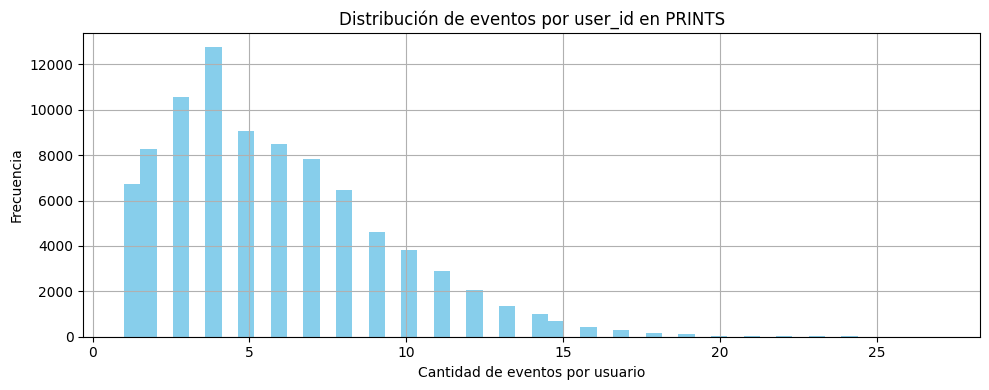

In [19]:
plt.figure(figsize=(10, 4))
df_prints_nuevo['user_id'].value_counts().plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribución de eventos por user_id en PRINTS')
plt.xlabel('Cantidad de eventos por usuario')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Mostrar la distribución de eventos por user_id en PRINTS
df_prints_nuevo["user_id"].value_counts()

user_id
35156    27
9704     27
88770    26
61554    26
5352     25
         ..
85508     1
49540     1
38057     1
38625     1
64670     1
Name: count, Length: 87864, dtype: int64

In [21]:
# Mostrar la distribución de eventos por posición en PRINTS
df_prints_nuevo["position"].value_counts()

position
0    203603
1    152513
2    101675
3     50826
Name: count, dtype: int64

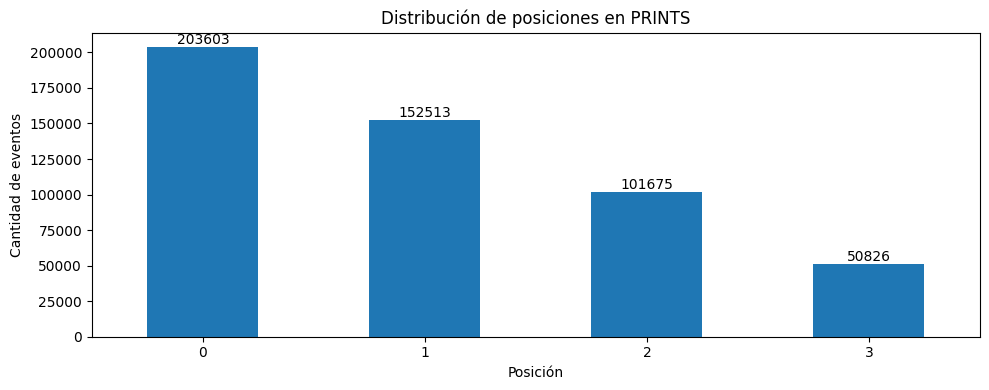

In [22]:
# Mostrar la distribución de eventos por posición en PRINTS
df_prints_nuevo["position"].value_counts().plot(kind='bar', figsize=(10, 4), title="Distribución de posiciones en PRINTS")
plt.xticks(rotation=0)
plt.xlabel("Posición")
plt.ylabel("Cantidad de eventos")  
plt.bar_label(plt.gca().containers[0], fmt='%d') 
plt.tight_layout()
plt.show()  

In [23]:
# Mostrar la distribución de 'value_prop' en PRINTS
df_prints_nuevo["value_prop"].value_counts()

value_prop
link_cobro            72883
credits_consumer      72860
cellphone_recharge    72717
point                 72713
transport             72602
prepaid               72476
send_money            72366
Name: count, dtype: int64

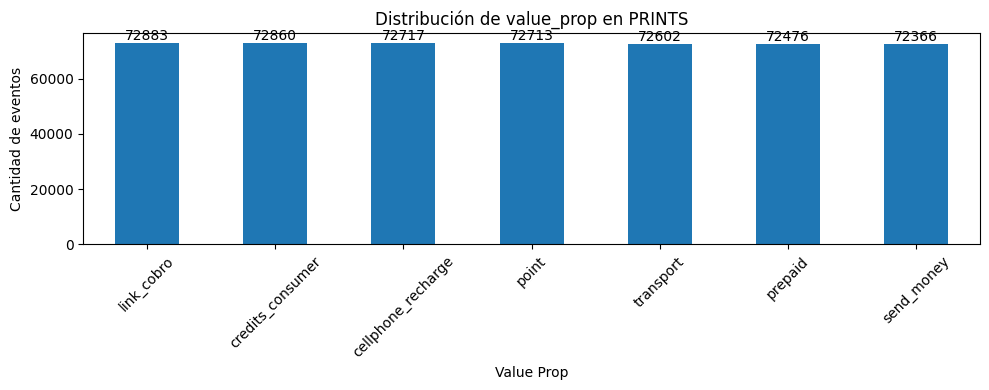

In [24]:
df_prints_nuevo["value_prop"].value_counts().plot(kind="bar", figsize=(10, 4), title="Distribución de value_prop en PRINTS")
plt.xticks(rotation=45)
plt.xlabel("Value Prop")
plt.ylabel("Cantidad de eventos")
plt.bar_label(plt.gca().containers[0], fmt='%d')
plt.tight_layout()
plt.show()

In [25]:
# Mostrar el tamaño del DataFrame resultante
df_taps_nuevo.shape

(50859, 4)

In [26]:
# Mostrar los tipos de datos de las columnas del DataFrame resultante
df_taps_nuevo.dtypes

day           datetime64[ns]
user_id                int64
position               int64
value_prop            object
dtype: object

In [27]:
# Mostrar información general del DataFrame resultante
df_taps_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50859 entries, 0 to 50858
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   day         50859 non-null  datetime64[ns]
 1   user_id     50859 non-null  int64         
 2   position    50859 non-null  int64         
 3   value_prop  50859 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.6+ MB


In [28]:
# Mostrar el número de filas duplicadas en el DataFrame resultante
df_taps_nuevo.duplicated().sum()

np.int64(0)

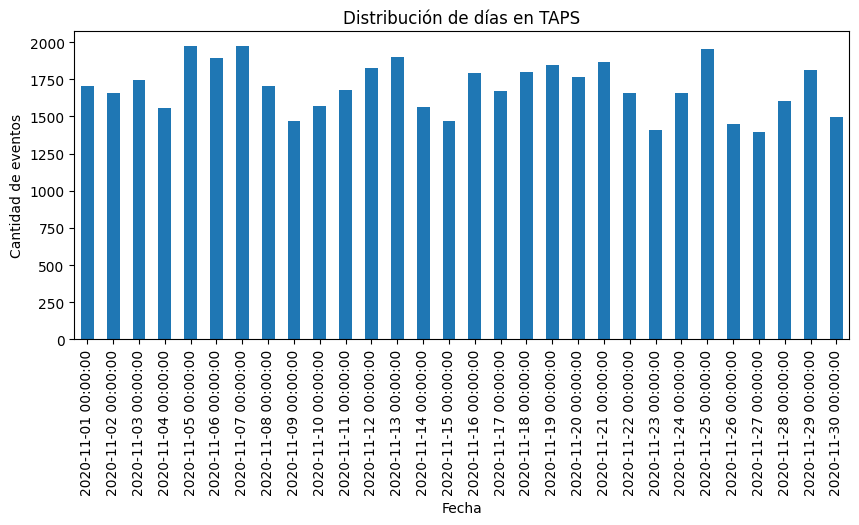

In [29]:
# Mostrar la distribución de días en taps
df_taps_nuevo.groupby("day").size().sort_index().plot(
    kind="bar",
    figsize=(10, 4),
    title="Distribución de días en TAPS"
)
plt.xticks(rotation=90)
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.show()

C:\Users\ingju\AppData\Local\Temp\ipykernel_31236\3039319377.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = dict(zip(unique_weeks, cm.get_cmap("tab10").colors[:len(unique_weeks)]))


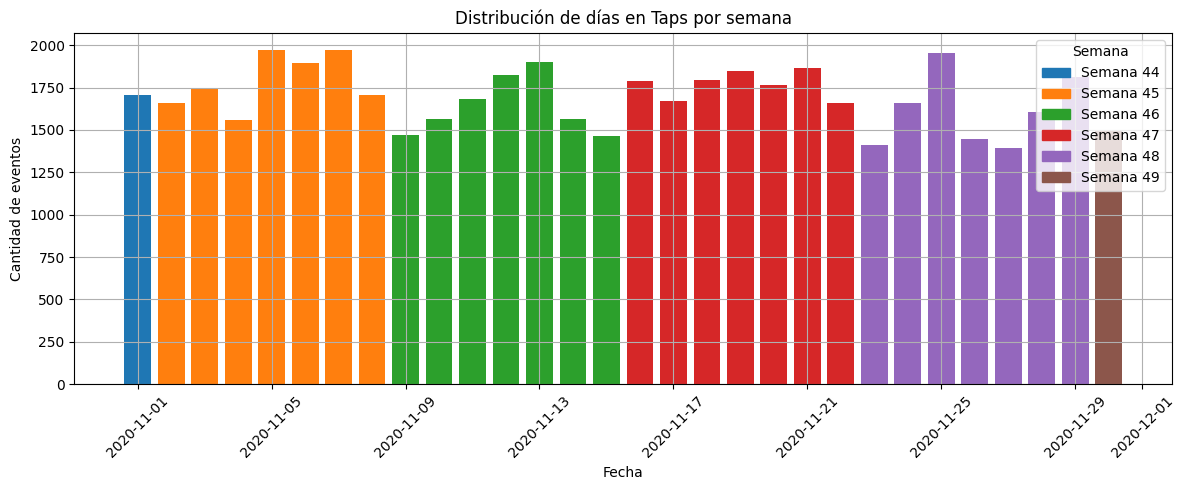

In [30]:

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Paso 1: }Calcular la semana

df_taps_nuevo["week"] = pd.to_datetime(df_taps_nuevo["day"]).dt.isocalendar().week

# Paso 2: Contar eventos por día
conteo_dias = df_taps_nuevo.groupby("day").size().sort_index()
fechas = conteo_dias.index

# Paso 3: Asignar color por semana
weeks = pd.to_datetime(fechas).isocalendar().week
unique_weeks = sorted(weeks.unique())
color_map = dict(zip(unique_weeks, cm.get_cmap("tab10").colors[:len(unique_weeks)]))
colors = [color_map[w] for w in weeks]

# Paso 4: Pintar la gráfica con colores por semana
plt.figure(figsize=(12, 5))
plt.bar(fechas, conteo_dias.values, color=colors)
plt.xticks(rotation=45)
plt.title("Distribución de días en Taps por semana")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.grid(True)

# Leyenda
handles = [plt.Rectangle((0,0),1,1, color=color_map[w]) for w in unique_weeks]
labels = [f"Semana {w}" for w in unique_weeks]
plt.legend(handles, labels, title="Semana")

plt.tight_layout()
plt.show()

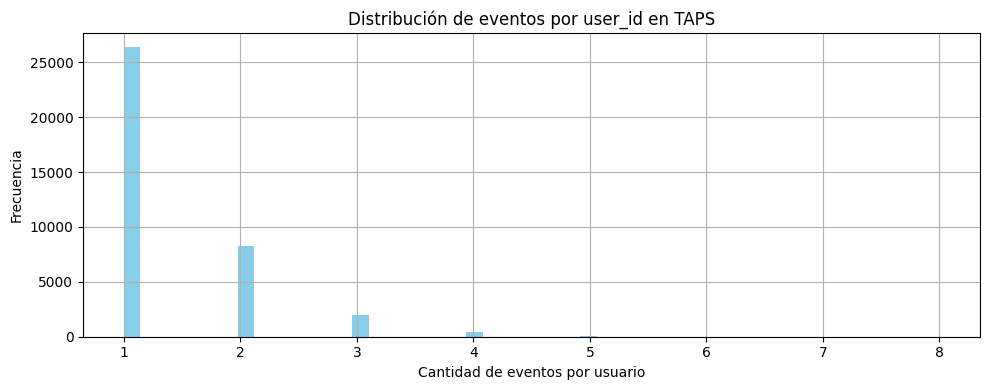

In [31]:
# Mostrar la distribución de eventos por user_id en TAPS
plt.figure(figsize=(10, 4))
df_taps_nuevo['user_id'].value_counts().plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribución de eventos por user_id en TAPS')
plt.xlabel('Cantidad de eventos por usuario')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Mostrar la distribución de eventos por user_id en TAPS
df_taps_nuevo["user_id"].value_counts()

user_id
52149    8
4647     7
67552    7
31210    7
47465    6
        ..
63650    1
60643    1
63808    1
1618     1
29807    1
Name: count, Length: 37057, dtype: int64

In [33]:
# Mostrar la distribución de eventos por posición en TAPS
df_taps_nuevo["position"].value_counts()

position
0    20285
1    15180
2    10094
3     5300
Name: count, dtype: int64

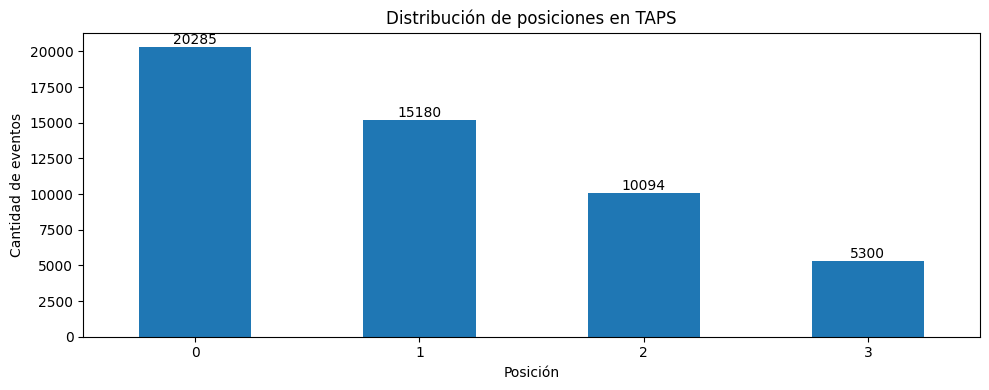

In [34]:
# Mostrar la distribución de eventos por posición en taps
df_taps_nuevo["position"].value_counts().plot(kind='bar', figsize=(10, 4), title="Distribución de posiciones en TAPS")
plt.xticks(rotation=0)
plt.xlabel("Posición")
plt.ylabel("Cantidad de eventos")  
plt.bar_label(plt.gca().containers[0], fmt='%d') 
plt.tight_layout()
plt.show()  

In [35]:
# Mostrar la distribución de 'value_prop' en taps
df_taps_nuevo["value_prop"].value_counts()

value_prop
credits_consumer      7363
cellphone_recharge    7344
link_cobro            7320
point                 7295
transport             7232
send_money            7172
prepaid               7133
Name: count, dtype: int64

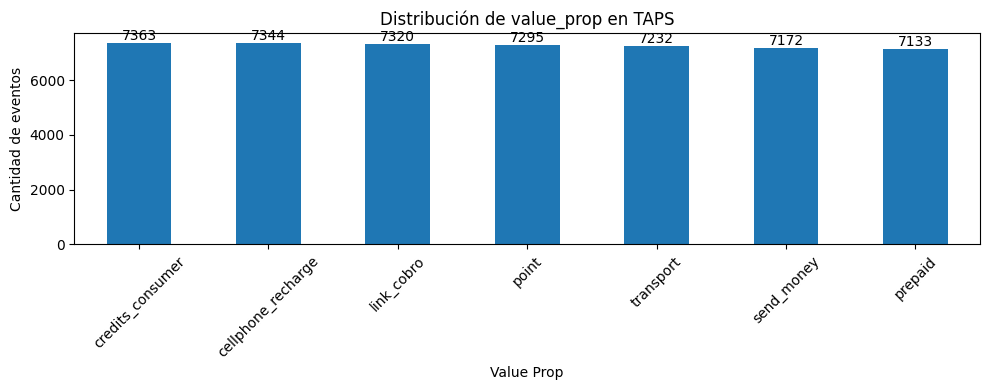

In [36]:
# Mostrar la distribución de 'value_prop' en taps
df_taps_nuevo["value_prop"].value_counts().plot(kind="bar", figsize=(10, 4), title="Distribución de value_prop en TAPS")
plt.xticks(rotation=45)
plt.xlabel("Value Prop")
plt.ylabel("Cantidad de eventos")
plt.bar_label(plt.gca().containers[0], fmt='%d')
plt.tight_layout()
plt.show()

In [37]:
# Mostrar el tamaño del DataFrame resultante
df_pays.shape

(756483, 4)

In [38]:
# Mostrar los tipos de datos de las columnas del DataFrame resultante
df_pays.dtypes

pay_date      datetime64[ns]
total                float64
user_id                int64
value_prop            object
dtype: object

In [39]:
# Mostrar información general del DataFrame resultante
df_pays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756483 entries, 0 to 756482
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   pay_date    756483 non-null  datetime64[ns]
 1   total       756483 non-null  float64       
 2   user_id     756483 non-null  int64         
 3   value_prop  756483 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 23.1+ MB


In [40]:
# Mostrar el número de filas duplicadas en el DataFrame resultante
df_pays.duplicated().sum()

np.int64(0)

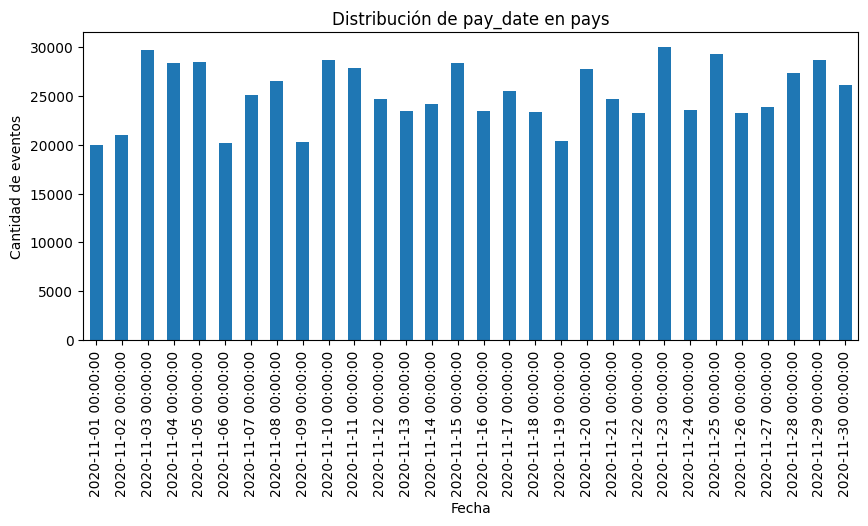

In [41]:
# Mostrar la distribución de pay_date en pays
df_pays.groupby("pay_date").size().sort_index().plot(
    kind="bar",
    figsize=(10, 4),
    title="Distribución de pay_date en pays"
)
plt.xticks(rotation=90)
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.show()

C:\Users\ingju\AppData\Local\Temp\ipykernel_31236\2336605343.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_pays = dict(zip(unique_weeks_pays, plt.cm.get_cmap("tab10").colors[:len(unique_weeks_pays)]))


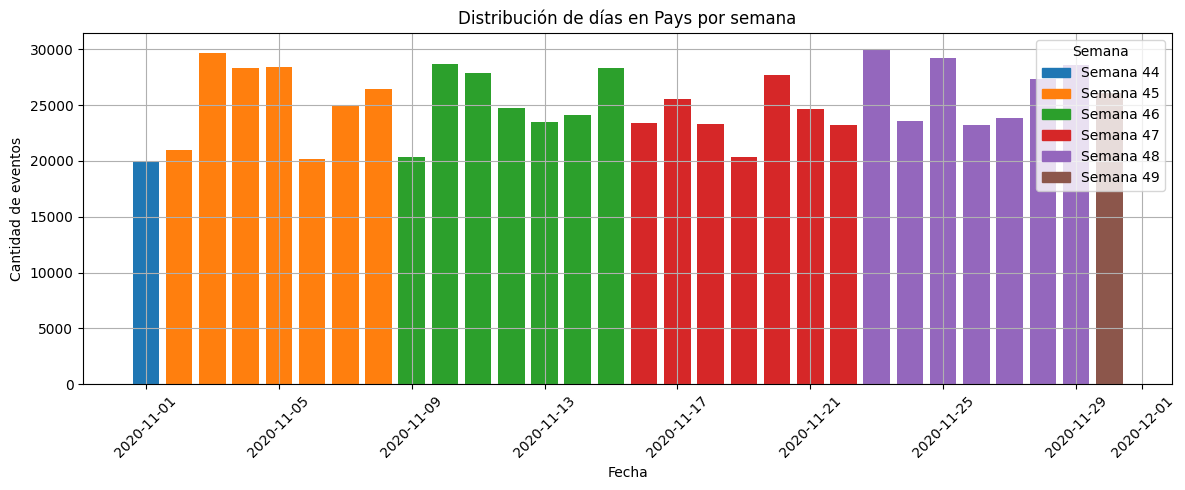

In [42]:
# Calcular la semana para df_pays
df_pays["week"] = df_pays["pay_date"].dt.isocalendar().week

# Contar eventos por día
conteo_dias_pays = df_pays.groupby("pay_date").size().sort_index()
fechas_pays = conteo_dias_pays.index

# Asignar color por semana
weeks_pays = pd.to_datetime(fechas_pays).isocalendar().week
unique_weeks_pays = sorted(weeks_pays.unique())
color_map_pays = dict(zip(unique_weeks_pays, plt.cm.get_cmap("tab10").colors[:len(unique_weeks_pays)]))
colors_pays = [color_map_pays[w] for w in weeks_pays]

# Pintar la gráfica con colores por semana
plt.figure(figsize=(12, 5))
plt.bar(fechas_pays, conteo_dias_pays.values, color=colors_pays)
plt.xticks(rotation=45)
plt.title("Distribución de días en Pays por semana")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.grid(True)

# Leyenda
handles_pays = [plt.Rectangle((0,0),1,1, color=color_map_pays[w]) for w in unique_weeks_pays]
labels_pays = [f"Semana {w}" for w in unique_weeks_pays]
plt.legend(handles_pays, labels_pays, title="Semana")

plt.tight_layout()
plt.show()

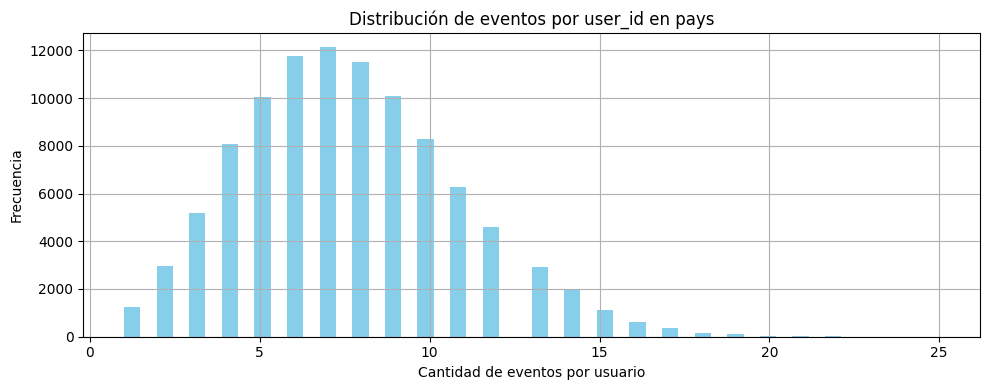

In [43]:
# Mostrar la distribución de eventos por  en pays
plt.figure(figsize=(10, 4))
df_pays['user_id'].value_counts().plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribución de eventos por user_id en pays')
plt.xlabel('Cantidad de eventos por usuario')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Mostrar la distribución de eventos por user_id en pays
df_pays["user_id"].value_counts()

user_id
4060     25
81857    24
82645    24
53530    24
65580    24
         ..
28780     1
13011     1
71623     1
70828     1
13744     1
Name: count, Length: 99605, dtype: int64

In [45]:
# Mostrar la distribución de 'value_prop' en pays
df_pays["value_prop"].value_counts()

value_prop
point                 108191
link_cobro            108172
credits_consumer      108149
transport             108106
prepaid               108051
send_money            107923
cellphone_recharge    107891
Name: count, dtype: int64

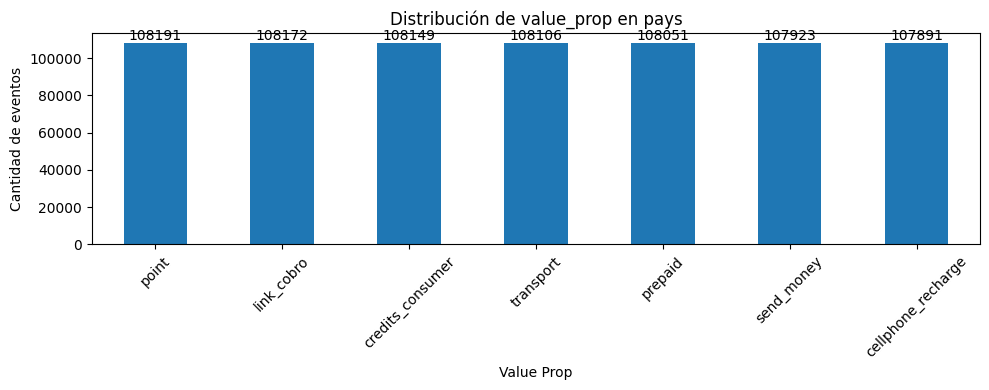

In [46]:
# Mostrar la distribución de 'value_prop' en pays
df_pays["value_prop"].value_counts().plot(kind="bar", figsize=(10, 4), title="Distribución de value_prop en pays")
plt.xticks(rotation=45)
plt.xlabel("Value Prop")
plt.ylabel("Cantidad de eventos")
plt.bar_label(plt.gca().containers[0], fmt='%d')
plt.tight_layout()
plt.show()

## ✅ Conclusiones del Análisis Exploratorio de Datos y Próximos Pasos

A partir del análisis exploratorio realizado sobre los datasets `prints`, `taps` y `pays`, se identificaron varios puntos importantes para el preprocesamiento de los datos y la construcción del dataset final:

### Principales conclusiones:
- La columna `event_data` en los archivos JSON contiene información esencial (como `position` y `value_prop`), pero está almacenada como un diccionario. Es necesario **expandir esta columna** en variables planas para poder utilizarlas.
- Las columnas que representan tiempo (`timestamp`, `day`) requieren conversión a tipo `datetime` para permitir operaciones temporales como filtros por semana.
- Se detectó la presencia de valores **nulos** y potenciales **duplicados**, por lo que será importante implementar un proceso de limpieza que los elimine o trate apropiadamente.
- Se observó una buena distribución temporal de eventos en los datos, lo que permitirá construir variables históricas confiables para alimentar el modelo.

### Próximas acciones:
1. Repetir la **expansión del campo `event_data`** para los tres datasets donde aplique (`prints`, `taps`).
2. Asegurar que todas las columnas de fechas estén en formato `datetime` y crear columnas auxiliares como `day` y `week` para facilitar agregaciones.
3. Implementar un **filtro para eliminar valores nulos y duplicados** que puedan afectar la calidad del dataset final.
4. Proceder con la construcción de variables históricas (ventanas de 3 semanas por cada print) y el ensamblado del dataset objetivo para el modelo de predicción.

Este trabajo de limpieza y transformación es clave para garantizar que el modelo posterior tenga datos consistentes, relevantes y correctamente estructurados.


listo ahora hay que redactar en un markdown las conclusiones y que es lo que vamos a hacer, entre ella repetir lo del split de las columnmas, convertir las columnas a datetime, 

In [47]:
from data_loader import load_all_data

prints, taps, pays = load_all_data()

prints.head()


ModuleNotFoundError: No module named 'data_loader'